In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from matplotlib import pyplot as plt

from models.cir import CoxIngersollRossModel

warnings.simplefilter('ignore', FutureWarning)

In [2]:
%load_ext autoreload
%autoreload 2

# US federal funds rate

In [3]:
df = pd.read_csv('./data_processing/data/fed-funds-rate-historical-chart.csv', parse_dates=[0])
df.columns = ['date', 'value']
df.head()

,date,value
0,1954-07-01,1.13
1,1954-07-02,1.25
2,1954-07-03,1.25
3,1954-07-04,1.25
4,1954-07-05,0.88


In [4]:
monthly_rate = df.groupby(
    df['date'].dt.strftime('%Y-%m-1')
)['value'].apply(lambda group: list(group)[0]).reset_index()
monthly_rate['date'] = pd.to_datetime(monthly_rate['date'])
monthly_rate.head()

,date,value
0,1954-07-01,1.13
1,1954-08-01,0.25
2,1954-09-01,1.44
3,1954-10-01,0.50
4,1954-11-01,1.38


In [5]:
monthly_rate = monthly_rate[(monthly_rate['date'].dt.year >= 2013) & (monthly_rate['date'].dt.month >= 9)]

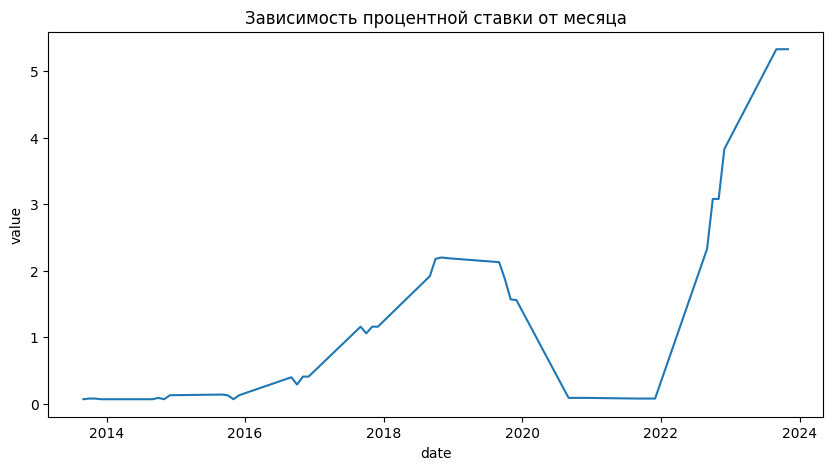

In [6]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_rate, x='date', y='value')
plt.title('Зависимость процентной ставки от месяца');

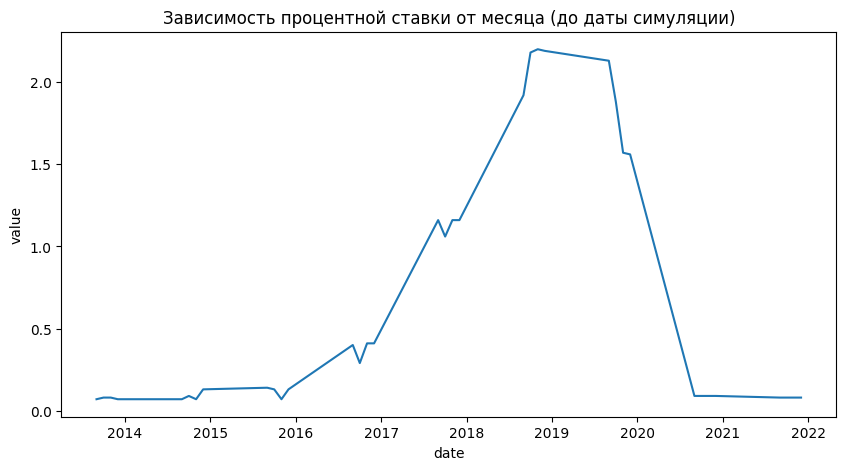

In [7]:
simulation_date = datetime.datetime(2021, 12, 10)
monthly_rate = monthly_rate[monthly_rate['date'] < simulation_date]
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_rate, x='date', y='value')
plt.title('Зависимость процентной ставки от месяца (до даты симуляции)');

In [15]:
r_start = 0.07
N = 12
T = 1
delta_t = T / N

cir = CoxIngersollRossModel(delta_t=delta_t)
cir.estimate_ols(monthly_rate['value'])
print(cir)

N_SIMULATIONS = 1000
TIME_STEPS_SIMULATIONS = 12
simulated_rate, expected_value, expected_error = cir.make_interest_rate_simulations(r_start, N_SIMULATIONS, TIME_STEPS_SIMULATIONS)
print("The expected value for the interest rate is:", "{}".format(expected_value))
print("The standard error of sample mean is:", "{}".format(expected_error))

CIR(a=0.4584534992969765, b=0.676335701607003, sigma=1.1788517605129802)
The expected value for the interest rate is: 0.29760113322331255
The standard error of sample mean is: 0.015002989047510486


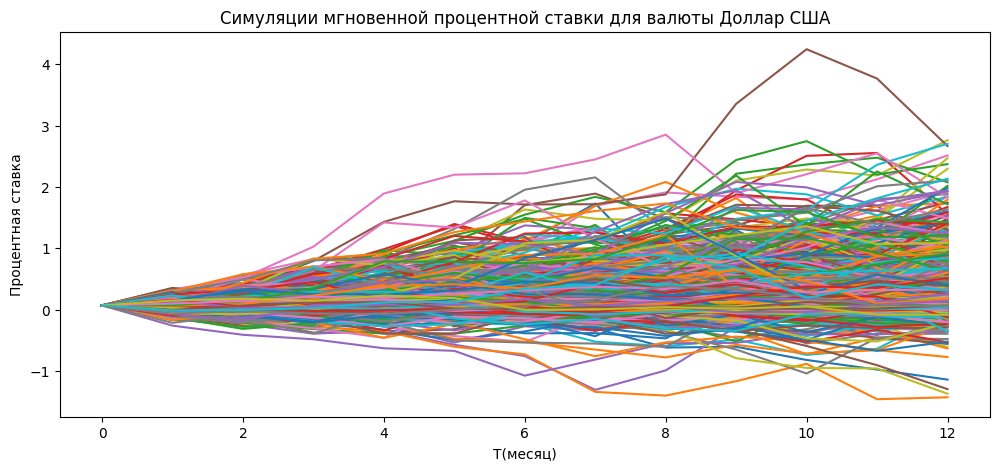

In [16]:
plt.figure(figsize=(12, 5))

for simulation in simulated_rate:
    plt.plot(np.arange(0, TIME_STEPS_SIMULATIONS + 1, 1), simulation)
plt.title('Симуляции мгновенной процентной ставки для валюты Доллар США')
plt.xlabel('T(месяц)')
plt.ylabel('Процентная ставка');

# US SOFR

In [17]:
df_sofr = pd.read_csv('./data_processing/data/SOFR.csv', parse_dates=['DATE'])
df_sofr.head()

,DATE,SOFR
0,2018-11-28,2.19
1,2018-11-29,2.24
2,2018-11-30,2.28
3,2018-12-03,2.23
4,2018-12-04,2.27


In [18]:
for row_index, row_data in df_sofr[df_sofr['SOFR'] == '.'].iterrows():
    df_sofr.loc[row_index, 'SOFR'] = (float(df_sofr.loc[row_index - 1, 'SOFR']) + float(df_sofr.loc[row_index + 1, 'SOFR'])) / 2
df_sofr['SOFR'] = df_sofr['SOFR'].astype(float)

In [19]:
monthly_rate_sofr = df_sofr.groupby(
    df_sofr['DATE'].dt.strftime('%Y-%m-1')
)['SOFR'].apply(lambda group: list(group)[0]).reset_index()
monthly_rate_sofr['DATE'] = pd.to_datetime(monthly_rate_sofr['DATE'])
monthly_rate_sofr.head()

,DATE,SOFR
0,2018-11-01,2.190
1,2018-12-01,2.230
2,2019-01-01,3.075
3,2019-02-01,2.470
4,2019-03-01,2.380


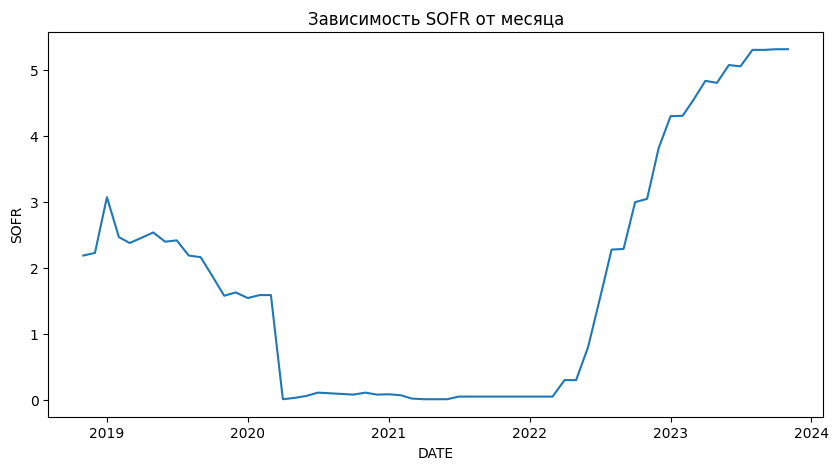

In [20]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_rate_sofr, x='DATE', y='SOFR')
plt.title('Зависимость SOFR от месяца');

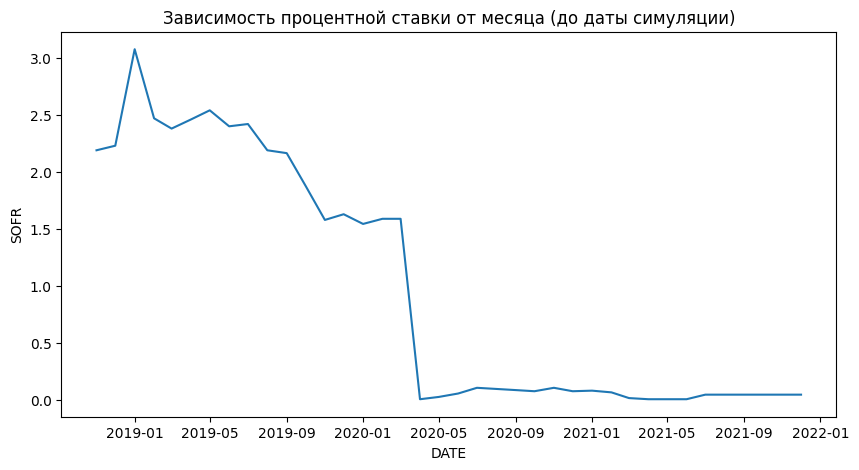

In [21]:
simulation_date = datetime.datetime(2021, 12, 10)
monthly_rate_sofr = monthly_rate_sofr[monthly_rate_sofr['DATE'] < simulation_date]
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_rate_sofr, x='DATE', y='SOFR')
plt.title('Зависимость процентной ставки от месяца (до даты симуляции)');

In [37]:
r_start_sofr = 0.05
N = 12
T = 1
delta_t = T / N

cir_sofr = CoxIngersollRossModel(delta_t=delta_t)
cir_sofr.estimate_ols(monthly_rate_sofr['SOFR'])
print(cir_sofr)
# cir_sofr.optimize_negative_likelihood(monthly_rate_sofr['SOFR'])
# print(cir_sofr)

N_SIMULATIONS = 1000
TIME_STEPS_SIMULATIONS = 12
simulated_rate_sofr, expected_value_sofr, expected_error_sofr = cir_sofr.make_interest_rate_simulations(
    r_start_sofr, N_SIMULATIONS, TIME_STEPS_SIMULATIONS
)
print("The expected value for the interest rate SOFR is:", "{}".format(expected_value_sofr))
print("The standard error of sample mean is:", "{}".format(expected_error_sofr))

CIR(a=0.814777301020875, b=0.1605996025481934, sigma=0.8595680925725696)
The expected value for the interest rate SOFR is: 0.10748131887878137
The standard error of sample mean is: 0.006195682664479059


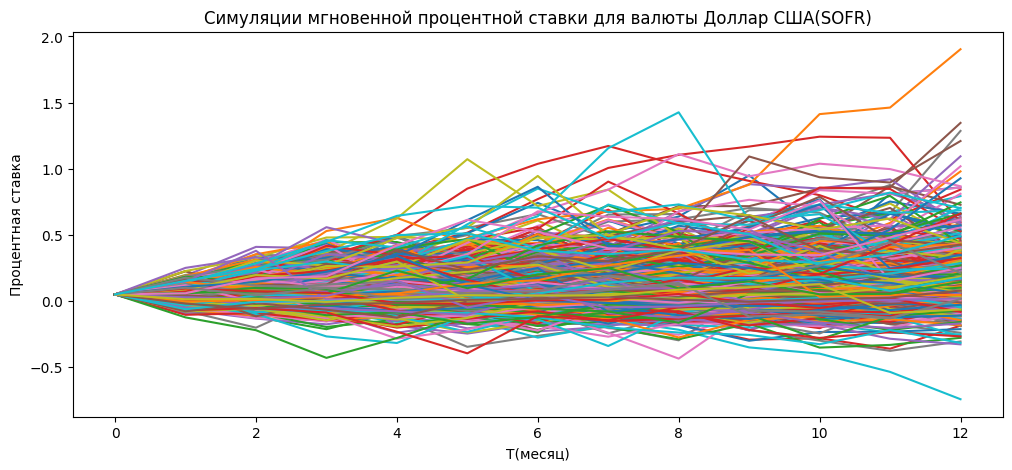

In [38]:
plt.figure(figsize=(12, 5))

for simulation in simulated_rate_sofr:
    plt.plot(np.arange(0, TIME_STEPS_SIMULATIONS + 1, 1), simulation)
plt.title('Симуляции мгновенной процентной ставки для валюты Доллар США(SOFR)')
plt.xlabel('T(месяц)')
plt.ylabel('Процентная ставка');